In [1]:
from zipfile import ZipFile

# Tentar usar RAPIDS com fallback pras libs normais
try:
    import cudf as pd
except ImportError:
    import pandas as pd

try:
    import cupy as np
except ImportError:
    import numpy as np

try:
    from cuml.ensemble import RandomForestClassifier
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import LabelEncoder
except ImportError:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report

In [2]:
IS_USING_RAPIDS = 'cudf' in pd.__name__
IS_USING_RAPIDS

False

In [3]:
DF_KWARGS = {'sep': ';'} if IS_USING_RAPIDS else {'encoding': 'utf8', 'on_bad_lines': 'warn', 'sep': ';'}

# Carregando todos os .csv como um dataframe só
with ZipFile('Microdados_Matricula.zip', 'r') as zip_file:
    dataframes = []

    for year in [2021, 2022, 2023]:
        csv_filename = f'microdados_matriculas_{year}.csv'

        with zip_file.open(csv_filename) as csv_file:
            _df = pd.read_csv(csv_file, **DF_KWARGS)
            dataframes.append(_df)

    df = pd.concat(dataframes, ignore_index=True)  # noqa: PD901

df.head()

,Ano,Carga Horaria,Carga Horaria Mínima,Categoria da Situação,Co Inst,Cod Unidade,Cor / Raça,Código da Matricula,Código da Unidade de Ensino - SISTEC,Código do Ciclo Matricula,...,Vagas Extraordinárias l9,Vagas Regulares AC,Vagas Regulares l1,Vagas Regulares l10,Vagas Regulares l13,Vagas Regulares l14,Vagas Regulares l2,Vagas Regulares l5,Vagas Regulares l6,Vagas Regulares l9
0,2021,200,200.0,Evadidos,26243,557,Amarela,96176470,3479.0,2716099,...,0.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2021,160,160.0,Em curso,26436,6002,Amarela,102483972,45430.0,2830452,...,0.0,2834.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2021,160,160.0,Em curso,26436,6002,Amarela,102459282,45430.0,2830437,...,0.0,1234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2021,40,160.0,Em curso,26419,116,Amarela,97887414,2936.0,2745532,...,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,2021,1380,1200.0,Em curso,26404,436,Amarela,91646798,2947.0,2632269,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [4]:
# Checando o formato do df
df.dtypes

Ano                                       int64
Carga Horaria                             int64
Carga Horaria Mínima                    float64
Categoria da Situação                    object
Co Inst                                   int64
Cod Unidade                               int64
Cor / Raça                               object
Código da Matricula                       int64
Código da Unidade de Ensino - SISTEC    float64
Código do Ciclo Matricula                 int64
Código do Município com DV                int64
Data de Fim Previsto do Ciclo            object
Data de Inicio do Ciclo                  object
Data de Ocorrencia da Matricula          object
Eixo Tecnológico                         object
Faixa Etária                             object
Fator Esforço Curso                      object
Fonte de Financiamento                   object
Idade                                   float64
Instituição                              object
Matrícula Atendida                      

In [5]:
EVAL_COLUMN = 'Categoria da Situação'  # A coluna que a gente quer prever
WANTED_COLUMNS = (
	'Ano',
	'Carga Horaria',
	'Carga Horaria Mínima',
	'Co Inst',
	'Cod Unidade',
	'Cor / Raça',
	'Código da Unidade de Ensino - SISTEC',
	# 'Código do Ciclo Matricula',
	'Código do Município com DV',
	'Data de Fim Previsto do Ciclo',
	'Data de Inicio do Ciclo',
	'Eixo Tecnológico',
	'Faixa Etária',
	'Fator Esforço Curso',
	'Fonte de Financiamento',
	'Idade',
	'Instituição',
	'Matrícula Atendida',
	'Modalidade de Ensino',
	'Município',
	'Nome de Curso',
	'Região',
	'Renda Familiar',
	'Sexo',
	'Subeixo Tecnológico',
	'Tipo de Curso',
	'Tipo de Oferta',
	'Total de Inscritos',
	'Turno',
	'UF',
	'Unidade de Ensino',
	'Vagas Extraordinárias AC',
	'Vagas Extraordinárias l1',
	'Vagas Extraordinárias l10',
	'Vagas Extraordinárias l13',
	'Vagas Extraordinárias l14',
	'Vagas Extraordinárias l2',
	'Vagas Extraordinárias l5',
	'Vagas Extraordinárias l6',
	'Vagas Extraordinárias l9',
	'Vagas Regulares AC',
	'Vagas Regulares l1',
	'Vagas Regulares l10',
	'Vagas Regulares l13',
	'Vagas Regulares l14',
	'Vagas Regulares l2',
	'Vagas Regulares l5',
	'Vagas Regulares l6',
	'Vagas Regulares l9',
)  # As colunas que fazem sentido ser avaliadas

In [6]:
df[EVAL_COLUMN].value_counts(normalize=True)  # Distribuição das classes na coluna que a gente quer prever

Categoria da Situação
Em curso       0.361439
Evadidos       0.179843
Concluintes    0.163807
Em Curso       0.147949
Concluídos     0.146963
Name: proportion, dtype: float64

In [7]:
df[EVAL_COLUMN] = (df[EVAL_COLUMN] != 'Evadidos').astype(int)
df[EVAL_COLUMN].value_counts(normalize=True)  # Distribuição das classes após padronização

Categoria da Situação
1    0.820157
0    0.179843
Name: proportion, dtype: float64

In [8]:
# Transformando todas as colunas de categóricas para numéricas
df_encoded = df[[EVAL_COLUMN, *WANTED_COLUMNS]].copy()
encoders = {}

for col in WANTED_COLUMNS:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    encoders[col] = le

df_encoded.dtypes

Categoria da Situação                   int64
Ano                                     int64
Carga Horaria                           int64
Carga Horaria Mínima                    int64
Co Inst                                 int64
Cod Unidade                             int64
Cor / Raça                              int64
Código da Unidade de Ensino - SISTEC    int64
Código do Município com DV              int64
Data de Fim Previsto do Ciclo           int64
Data de Inicio do Ciclo                 int64
Eixo Tecnológico                        int64
Faixa Etária                            int64
Fator Esforço Curso                     int64
Fonte de Financiamento                  int64
Idade                                   int64
Instituição                             int64
Matrícula Atendida                      int64
Modalidade de Ensino                    int64
Município                               int64
Nome de Curso                           int64
Região                            

In [ ]:
# Vamos usar Cramér's V para calcular a correlação entre variáveis categóricas
def cramers(x: pd.Series, y: pd.Series) -> float:
    """
    Calcula a associação de duas váriaveis categóricas.

    https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V#Calculation

    Args:
        x (pd.Series): Série de dados da primeira variável categórica
        y (pd.Series): Série de dados da segunda variável categórica

    Returns:
        float: Correlação entre as variáveis, variando de 0 (sem associação) à 1 (associação perfeita).
    """
    confusion_matrix = pd.crosstab(x, y)

    chi2 = chi2_contingency(confusion_matrix.to_numpy())[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1

    # Caso uma das variáveis seja constante
    if min_dim == 0:
        return 0.0

    return np.sqrt(chi2 / (n * min_dim)).get().item(0) if IS_USING_RAPIDS else np.sqrt(chi2 / (n * min_dim))

In [10]:
# Calculando a correlação entre todas as colunas e a coluna de avaliação
correlations = {}

for col in WANTED_COLUMNS:
    correlations[col] = cramers(df[col], df[EVAL_COLUMN])

sorted_corr = pd.Series(correlations).sort_values(ascending=False)
sorted_corr  # Correlações ordenadas

Cod Unidade                             0.366456
Código da Unidade de Ensino - SISTEC    0.366248
Unidade de Ensino                       0.365517
Código do Município com DV              0.335940
Instituição                             0.335858
Vagas Regulares AC                      0.327602
Data de Fim Previsto do Ciclo           0.327014
Total de Inscritos                      0.315324
Data de Inicio do Ciclo                 0.313140
Carga Horaria                           0.307483
Nome de Curso                           0.298812
Região                                  0.283388
Co Inst                                 0.279984
UF                                      0.227878
Carga Horaria Mínima                    0.170030
Fator Esforço Curso                     0.148727
Tipo de Curso                           0.145892
Tipo de Oferta                          0.145457
Município                               0.126411
Vagas Extraordinárias AC                0.124781
Turno               

In [ ]:


X = df_encoded.drop(EVAL_COLUMN, axis=1).fillna(0)  # Features
y = df_encoded[EVAL_COLUMN]  # Target

# Splittar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y,
)

In [ ]:
# Treinando um modelo simples de RandomForest para prever a coluna de avaliação
# Escolhemos Random Forest pois:
# 1. Tem um método "integrado" para avaliar a importância dos recursos
# 2. Lida bem com alta dimensionalidade (temos ~50 features)


model = RandomForestClassifier(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))  # Relatório de classificação gerado pelo sklearn

              precision    recall  f1-score   support

           0       0.65      0.55      0.60    169697
           1       0.90      0.94      0.92    773890

    accuracy                           0.87    943587
   macro avg       0.78      0.74      0.76    943587
weighted avg       0.86      0.87      0.86    943587



In [ ]:
if not IS_USING_RAPIDS:
    # Printando a importância das features em ordem decrescente
    feature_importance = pd.Series(
        model.feature_importances_,
        index=X.columns,
    ).sort_values(ascending=False)

    print(feature_importance)

Idade                                   0.153639
Renda Familiar                          0.093134
Cor / Raça                              0.070984
Faixa Etária                            0.057853
Data de Inicio do Ciclo                 0.047449
Carga Horaria                           0.044717
Total de Inscritos                      0.041813
Data de Fim Previsto do Ciclo           0.038635
Sexo                                    0.036423
Código do Município com DV              0.032615
Vagas Regulares AC                      0.030577
Instituição                             0.026946
Ano                                     0.024813
Cod Unidade                             0.024336
Código da Unidade de Ensino - SISTEC    0.023804
Região                                  0.021904
Nome de Curso                           0.018858
Unidade de Ensino                       0.018002
Co Inst                                 0.017858
Município                               0.014737
Carga Horaria Mínima

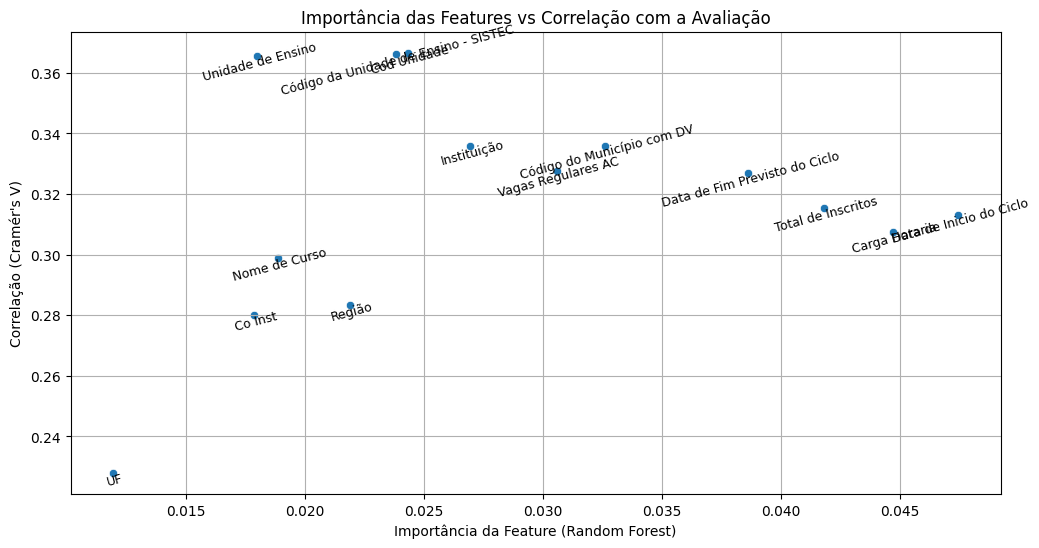

In [15]:
# Plotando a importância das features x correlação para cada coluna que tenha correlação > 0.2
important_features = sorted_corr[sorted_corr > 0.2].index.tolist()

if not IS_USING_RAPIDS:
	plt.figure(figsize=(12, 6))
	sns.scatterplot(
		x=feature_importance[important_features],
		y=sorted_corr[important_features],
	)

	# Adicionando anotações para cada ponto se o ponto não for muito próximo de outro
	for feature in important_features:
		plt.text(
			feature_importance[feature],
			sorted_corr[feature],
			feature,
			fontsize=9,
			ha='center',
			va='top',
			rotation=15,
			rotation_mode='anchor',
		)

	plt.xlabel('Importância da Feature (Random Forest)')
	plt.ylabel("Correlação (Cramér's V)")
	plt.title('Importância das Features vs Correlação com a Avaliação')
	plt.grid(True)
	plt.show()

In [ ]:
if not IS_USING_RAPIDS:
	feature_analysis = pd.DataFrame({
		'Feature Importance': feature_importance,
		'Cramérs V Correlation': sorted_corr,
	})

	print(feature_analysis)
	feature_analysis.to_csv('feature_analysis.csv')

                                      Feature Importance  \
Ano                                             0.024813   
Carga Horaria                                   0.044717   
Carga Horaria Mínima                            0.014220   
Co Inst                                         0.017858   
Cod Unidade                                     0.024336   
Cor / Raça                                      0.070984   
Código da Unidade de Ensino - SISTEC            0.023804   
Código do Município com DV                      0.032615   
Data de Fim Previsto do Ciclo                   0.038635   
Data de Inicio do Ciclo                         0.047449   
Eixo Tecnológico                                0.009559   
Faixa Etária                                    0.057853   
Fator Esforço Curso                             0.012456   
Fonte de Financiamento                          0.010914   
Idade                                           0.153639   
Instituição                             